# Iterations on preprocessing

Let's restart from scratch on lowercased questions.

Note we will loose some information by lowercasing everything...


In [2]:
# Ugly incantation to make our 'framework' working
import sys
sys.path.insert(0, r'/SAPDevelop/QuoraPairs/BruteForce/Tools')

#import all our small tools (paths, cache, print,zip,excel, pandas, progress,..)
from Tools.all import *

# setup the name of our experiment
# it will be used to store every result in a unique place
EXPERIMENT='preprocessing'
# Do a bit of checks before actually running long code
UNITARY_TEST = True
print_alert('You will use environment %s' % EXPERIMENT)

prepare_environnement(EXPERIMENT)
train_dataframe=load_dataframe(CLEAN_TRAINING_DATA)
challenge_dataframe=load_dataframe(CLEAN_CHALLENGE_DATA)
print_section('Untouched input data has been loaded. Training: %d lines Challenge: %d lines' % (len(train_dataframe),len(challenge_dataframe)))

## Challenge and training are not equivalent

% of duplicate in training is not the same in challenge !
We don't have the challenge's answer but by scoring a constant prediction and using logloss definition, we can guess the distribution of duplicates in challenge

It's 17.46 %

To fix that we can:

* duplicate some negative cases in training to match challenge distribution
* use weights : each case has a weight !=1 and all algorithms are supposed to be able to deal with that info
I choose to use weights (less memory needed ?)

In [3]:

CHALLENGE_DUPLICATE_PERCENT = 0.1746

#return the weight for 0 and weight for 1 needed to rebalance dataframe like challenge
def balanced_weights(dataframe,expected_positive_ratio):
    current_positive_ratio = dataframe['is_duplicate'].sum()/len(dataframe)
    weight_for_negative = (1-expected_positive_ratio)/(1-current_positive_ratio)
    weight_for_positive = expected_positive_ratio/current_positive_ratio
    return weight_for_positive,weight_for_negative

print_warning('OUPS !! %% of duplicates in train is %.3f. In challenge it is %.3f %%' % (train_dataframe['is_duplicate'].sum()/len(train_dataframe),CHALLENGE_DUPLICATE_PERCENT))

# create a new 'weight' column to training dataset
# Do not forget to remove this column from features !!!
print_warning("let's add some weights to rebalance the data")
weight_for_1,weight_for_0 = balanced_weights(train_dataframe,CHALLENGE_DUPLICATE_PERCENT)
print_info('Weight for positive case %.3f' % weight_for_1)
print_info('Weight for negative case %.3f' % weight_for_0)
train_dataframe['weight'] = train_dataframe['is_duplicate'].map( {0:weight_for_0, 1:weight_for_1})

assert int(train_dataframe['weight'].sum()/len(train_dataframe)) == 1, "training dataset has not been properly rebalanced"
print_info("Training data set has been properly rebalanced")
print_info('Weights distribution:')
train_dataframe['weight'].describe()

count    404290.000000
mean          1.000000
std           0.403239
min           0.472917
25%           0.472917
50%           1.308493
75%           1.308493
max           1.308493
Name: weight, dtype: float64

### Step 1: Lower case everything

In [4]:
# our main tool to add feature
def add_column_from_columns(dataframe,output_column_name,function):
    dataframe[output_column_name]=dataframe.progress_apply(function,axis=1)
    return dataframe[output_column_name]

def add_column_from_column(dataframe,output_column_name,input_column_name,function):
    dataframe[output_column_name]=dataframe[input_column_name].progress_apply(function)
    return dataframe[output_column_name]
    
def build_all_lower_data(dataframe):
    print_info('Lower case question1')
    dataframe['question1'] = dataframe['question1'].str.lower()
    print_info('Lower case question2')
    dataframe['question2'] = dataframe['question2'].str.lower()
    return dataframe

train_dataframe = load_or_build_dataframe('Lower case everything in training','training_lower',build_all_lower_data,train_dataframe)
challenge_dataframe = load_or_build_dataframe('Lower case everything in challenge','challenge_lower',build_all_lower_data,challenge_dataframe)

### Step 2 : build our basic features
* Nb words in question 1
* Nb words in question 2
* Nb common words
* Nb common words/nb words in question 1
* Nb common words/nb words in question 2
* Nb non common words in question 1
* Nb non common words in question 2
* Nb common words/(Nb words in question1 + Nb words in question2)

Note this is done on raw question content : no preprocessing

In [5]:
def build_basic_features_one_row(q1,q2):
    q1 = set(q1.split())
    len_q1 = len(q1)
    q2 = set(q2.split())
    len_q2 = len(q2)

    common = q1&q2
    len_common = len(common)

    uncommon_q1 = q1-common
    len_uncommon_q1 = len(uncommon_q1)

    uncommon_q2 = q2-common
    len_uncommon_q2 = len(uncommon_q2)
    #       0     1           2            3         4               5               6      7      8                        9                        10
    return common,uncommon_q1,uncommon_q2,len_common,len_uncommon_q1,len_uncommon_q2,len_q1,len_q2,len_common/max(1,len_q1),len_common/max(1,len_q2),len_common/(len_q1+len_q2)
    
def build_all_basic_features(dataframe):
    print_warning('Compute all features in one shot')
    add_column_from_columns(dataframe,'temp',lambda r: build_basic_features_one_row(r.question1,r.question2))
    
    print_warning('Extract nb_words_question1')
    add_column_from_column(dataframe,'nb_words_question1','temp',lambda x: x[6])
    print_warning('Extract nb_words_question2')
    add_column_from_column(dataframe,'nb_words_question2','temp',lambda x: x[7])

    print_warning('Extract Nb common_words between question1 & question2')
    add_column_from_column(dataframe,'nb_common_words','temp',lambda x: x[3])

    print_warning('Extract Nb common words/nb words in question1')
    add_column_from_column(dataframe,'nb_common_words/nb_words_question1','temp',lambda x: x[8])

    print_warning('Extract Nb common words/nb words in question2')
    add_column_from_column(dataframe,'nb_common_words/nb_words_question2','temp',lambda x: x[9])

    print_warning('Extract Nb words in question1 not in common words')
    add_column_from_column(dataframe,'nb_words_question1-common_words','temp',lambda x: x[4])

    print_warning('Extract Nb words in question2 not in common words')
    add_column_from_column(dataframe,'nb_words_question2-common_words','temp',lambda x: x[5])

    print_warning('Compute (nb common words)/(nb words in question1+nb word in question2)')
    add_column_from_column(dataframe,'nb_common_words/(nb_words_question1+nb_words_question2)','temp',lambda x: x[10])
    
    print_warning('Extract common words between question1 & question2')
    add_column_from_column(dataframe,'common_words','temp',lambda x: x[0])
    
    print_warning('Extract uncommon words in question1')
    add_column_from_column(dataframe,'uncommon_words_question1','temp',lambda x: x[1])

    print_warning('Extract uncommon words in question2')
    add_column_from_column(dataframe,'uncommon_words_question2','temp',lambda x: x[2])
    dataframe = dataframe.drop (columns='temp')  
    return dataframe


train_dataframe = load_or_build_dataframe('Training data + basic features','training_basic_features',build_all_basic_features,train_dataframe)
challenge_dataframe = load_or_build_dataframe('Challenge data + basic features','challenge_basic_features',build_all_basic_features,challenge_dataframe)

Let's take a look in our new data

In [6]:
train_dataframe.head(2).transpose()

0  \
id                                                                                                                        0   
qid1                                                                                                                      1   
qid2                                                                                                                      2   
question1                                                what is the step by step guide to invest in share market in india?   
question2                                                         what is the step by step guide to invest in share market?   
is_duplicate                                                                                                              0   
weight                                                                                                              1.30849   
nb_words_question1                                                                                                       12   
nb_words_question2                                                                                                       11   
nb_common_words                                                                                                          10   
nb_common_words/nb_words_question1                                                                                 0.833333   
nb_common_words/nb_words_question2                                                                                 0.909091   
nb_words_question1-common_words                                                                                           2   
nb_words_question2-common_words                                                                                           1   
nb_common_words/(nb_words_question1+nb_words_question2)                                                            0.434783   
common_words                                                        {share, is, what, step, guide, to, in, the, by, invest}   
uncommon_words_question1                                                                                   {market, india?}   
uncommon_words_question2                                                                                          {market?}   

                                                                                                                                                1  
id                                                                                                                                              1  
qid1                                                                                                                                            3  
qid2                                                                                                                                            4  
question1                                                                                     what is the story of kohinoor (koh-i-noor) diamond?  
question2                                                what would happen if the indian government stole the kohinoor (koh-i-noor) diamond back?  
is_duplicate                                                                                                                                    0  
weight                                                                                                                                    1.30849  
nb_words_question1                                                                                                                              8  
nb_words_question2                                                                                                                             12  
nb_common_words                                                                                                                                 4  
nb_common_words/nb_words_question1                                              

Let's take a look in common words & uncommon_words_question1

In [7]:
train_dataframe[['common_words','uncommon_words_question1']]

common_words  \
0                                   {share, is, what, step, guide, to, in, the, by, invest}   
1                                                       {the, (koh-i-noor), kohinoor, what}   
2                                                               {can, internet, speed, how}   
3                                                                                        {}   
4                                                                               {in, which}   
...                                                                                     ...   
404285  {version?, programming, many, language, how, latest, in, the, there, are, keywords}   
404286                                                     {is, after, there, life, death?}   
404287                                                                              {coin?}   
404288                                                                                 {of}   
404289                                       {have, is, like, to, cousin?, with, sex, what}   

                                                                                            uncommon_words_question1  
0                                                                                                   {market, india?}  
1                                                                                          {of, diamond?, story, is}  
2                                                      {using, vpn?, of, connection, a, the, my, i, increase, while}  
3                                                        {why, very, it?, solve, how, mentally, can, i, am, lonely?}  
4                                    {sugar,, water, one, salt,, and, di, methane, carbon, oxide?, quikly, dissolve}  
...                                                                                                              ...  
404285                                                                                                  {of, racket}  
404286                                                                                            {believe, you, do}  
404287                                                                                               {one, what, is}  
404288  {for, indian, is, living, what, chicago,, in, the, annual, student?, an, cost, studying, approx, uic, while}  
404289                                                                                                            {}  

[404290 rows x 2 columns]

OK common words and uncommon words are polluted by tons of words like: is,with,to,..  

These are stop words.

### Step 3 : remove a first set of stop words
We start with stopwords coming from nltk

In [8]:
from nltk.corpus import stopwords

def build_no_stopwords_features_one_row(q1,q2,stopwords):
    q1 = set([w for w in q1.split() if w not in stopwords])
    len_q1 = len(q1)
    q2 = set([w for w in q2.split() if w not in stopwords])
    len_q2 = len(q2)

    common = q1&q2
    len_common = len(common)

    uncommon_q1 = q1-common
    len_uncommon_q1 = len(uncommon_q1)

    uncommon_q2 = q2-common
    len_uncommon_q2 = len(uncommon_q2)
    #       0     1           2            2         4               5               6      7      8                        9                        10
    return common,uncommon_q1,uncommon_q2,len_common,len_uncommon_q1,len_uncommon_q2,len_q1,len_q2,len_common/max(1,len_q1),len_common/max(1,len_q2),len_common/max(1,(len_q1+len_q2))
    

def build_nltk_stop_words_features(dataframe):
    print_warning('Remove stopwords from question 1 & question2')
    
    print_warning('Compute all nltk features in one shot')
    add_column_from_columns(dataframe,'temp',lambda r: build_no_stopwords_features_one_row(r.question1,r.question2,nltk_stopwords))
    
    print_warning('Extract nb_words_question1')
    add_column_from_column(dataframe,'nltk_nb_words_question1','temp',lambda x: x[6])
    print_warning('Extract nb_words_question2')
    add_column_from_column(dataframe,'nltk_nb_words_question2','temp',lambda x: x[7])

    print_warning('Extract Nb common_words between question1 & question2')
    add_column_from_column(dataframe,'nltk_nb_common_words','temp',lambda x: x[3])

    print_warning('Extract Nb common words/nb words in question1')
    add_column_from_column(dataframe,'nltk_nb_common_words/nltk_nb_words_question1','temp',lambda x: x[8])

    print_warning('Extract Nb common words/nb words in question2')
    add_column_from_column(dataframe,'nltk_nb_common_words/nltk_nb_words_question2','temp',lambda x: x[9])

    print_warning('Extract Nb words in question1 not in common words')
    add_column_from_column(dataframe,'nltk_nb_words_question1-nltk_common_words','temp',lambda x: x[4])

    print_warning('Extract Nb words in question2 not in common words')
    add_column_from_column(dataframe,'nltk_nb_words_question2-nltk_common_words','temp',lambda x: x[5])

    print_warning('Compute (nb common words)/(nb words in question1+nb word in question2)')
    add_column_from_column(dataframe,'nltk_nb_common_words/(nltk_nb_words_question1+nltk_nb_words_question2)','temp',lambda x: x[10])
    
    print_warning('Extract common words between question1 & question2')
    add_column_from_column(dataframe,'nltk_common_words','temp',lambda x: x[0])
    
    print_warning('Extract uncommon words in question1')
    add_column_from_column(dataframe,'nltk_uncommon_words_question1','temp',lambda x: x[1])

    print_warning('Extract uncommon words in question2')
    add_column_from_column(dataframe,'nltk_uncommon_words_question2','temp',lambda x: x[2])
    dataframe = dataframe.drop (columns='temp')  
    return dataframe

nltk_stopwords = set(stopwords.words('english'))
print_info( 'There is %d stopwords in nltk' % len(nltk_stopwords))

train_dataframe = load_or_build_dataframe('Training: Build features aware of nltk stopwords','training_nltk_stop_words_features',build_nltk_stop_words_features,train_dataframe)
challenge_dataframe = load_or_build_dataframe('Challenge: Build features aware of nltk stopwords','challenge_nltk_stop_words_features',build_nltk_stop_words_features,challenge_dataframe)

Did we change anything ?

In [9]:
nb_changed_train = int(numpy.where(train_dataframe['nltk_nb_common_words']!=train_dataframe['nb_common_words'],1,0).sum())
print_info('We have changed %.2f %% of nb common_words in training!!' % (nb_changed_train*100./len(train_dataframe)))
nb_changed_challenge = int(numpy.where(challenge_dataframe['nltk_nb_common_words']!=challenge_dataframe['nb_common_words'],1,0).sum())
print_info('We have changed %.2f %% of nb common_words in challenge !!' % (nb_changed_challenge*100./len(challenge_dataframe)))
train_dataframe[['common_words','nltk_common_words','uncommon_words_question1','nltk_uncommon_words_question1']].head(2)

common_words             nltk_common_words   uncommon_words_question1 nltk_uncommon_words_question1
0  {share, is, what, step, guide, to, in, the, by, invest}  {guide, step, share, invest}           {market, india?}              {market, india?}
1                      {the, (koh-i-noor), kohinoor, what}      {(koh-i-noor), kohinoor}  {of, diamond?, story, is}             {diamond?, story}

Step 4: remove more stopwords coming from sklearn


In [10]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

sk_stopwords = set(ENGLISH_STOP_WORDS)
print_info('There is %d words in nltk stop words' % len(nltk_stopwords))
print_info('There is %d words in sklearn stop words' % len(sk_stopwords))
new_stopwords = [w for w in sk_stopwords if w not in nltk_stopwords]
print_info('There is %d new stop words in sklearn stop words' % len(new_stopwords))

all_stop_words = nltk_stopwords | sk_stopwords
print_info('There is %d words in the union of stop words' % len(all_stop_words))

def build_all_stop_words_features(dataframe): 
    print_warning('Compute all features in one shot')
    add_column_from_columns(dataframe,'temp',lambda r: build_no_stopwords_features_one_row(r.question1,r.question2,all_stop_words))
    
    print_warning('Extract nb_words_question1')
    add_column_from_column(dataframe,'all_nb_words_question1','temp',lambda x: x[6])
    print_warning('Extract nb_words_question2')
    add_column_from_column(dataframe,'all_nb_words_question2','temp',lambda x: x[7])

  
    print_warning('Extract Nb common_words between question1 & question2')
    add_column_from_column(dataframe,'all_nb_common_words','temp',lambda x: x[3])

    print_warning('Extract Nb common words/nb words in question1')
    add_column_from_column(dataframe,'all_nb_common_words/all_nb_words_question1','temp',lambda x: x[8])

    print_warning('Extract Nb common words/nb words in question2')
    add_column_from_column(dataframe,'all_nb_common_words/all_nb_words_question2','temp',lambda x: x[9])

    print_warning('Extract Nb words in question1 not in common words')
    add_column_from_column(dataframe,'all_nb_words_question1-all_common_words','temp',lambda x: x[4])

    print_warning('Extract Nb words in question2 not in common words')
    add_column_from_column(dataframe,'all_nb_words_question2-all_common_words','temp',lambda x: x[5])

    print_warning('Compute (nb common words)/(nb words in question1+nb word in question2)')
    add_column_from_column(dataframe,'all_nb_common_words/(all_nb_words_question1+all_nb_words_question2)','temp',lambda x: x[10])
    
    print_warning('Extract common words between question1 & question2')
    add_column_from_column(dataframe,'all_common_words','temp',lambda x: x[0])
    
    print_warning('Extract uncommon words in question1')
    add_column_from_column(dataframe,'all_uncommon_words_question1','temp',lambda x: x[1])

    print_warning('Extract uncommon words in question2')
    add_column_from_column(dataframe,'all_uncommon_words_question2','temp',lambda x: x[2])
    dataframe = dataframe.drop (columns='temp')  
    return dataframe


train_dataframe = load_or_build_dataframe('Training: Build features aware of all stopwords','training_all_stop_words_features',build_all_stop_words_features,train_dataframe)
challenge_dataframe = load_or_build_dataframe('Challenge: Build features aware of all stopwords','challenge_all_stop_words_features',build_all_stop_words_features,challenge_dataframe)

Try to recap the changes we made

In [11]:
nb_changed_train = int(numpy.where(train_dataframe['nltk_nb_common_words'] != train_dataframe['nb_common_words'],1,0).sum())
print_info('With nltk stop words we have changed %.2f %% of nb common_words in training!!' % (nb_changed_train*100./len(train_dataframe)))
nb_changed_train = int(numpy.where(train_dataframe['all_nb_common_words'] != train_dataframe['nb_common_words'],1,0).sum())
print_warning('Removing also sklearn stop words we have changed %.2f %% of nb common_words in training!!' % (nb_changed_train*100./len(train_dataframe)))

nb_changed_challenge = int(numpy.where(challenge_dataframe['nltk_nb_common_words']!=challenge_dataframe['nb_common_words'],1,0).sum())
print_info('With nltk stop words We have changed %.2f %% of nb common_words in challenge !!' % (nb_changed_challenge*100./len(challenge_dataframe)))
nb_changed_challenge = int(numpy.where(challenge_dataframe['all_nb_common_words']!=challenge_dataframe['nb_common_words'],1,0).sum())
print_warning('Removing also sklearn stop words we have changed %.2f %% of nb common_words in challenge !!' % (nb_changed_challenge*100./len(challenge_dataframe)))

changed = train_dataframe[train_dataframe['nltk_nb_common_words']!=train_dataframe['all_nb_common_words']]
changed[['common_words','nltk_common_words','all_common_words','uncommon_words_question1','nltk_uncommon_words_question1','all_uncommon_words_question1']].head(3)

common_words                nltk_common_words          all_common_words uncommon_words_question1 nltk_uncommon_words_question1  \
13                                   {sexual, first, was, your, what}                  {first, sexual}                  {sexual}      {like?, experience}           {like?, experience}   
30                             {better?, one, do, thing, what's, you}    {thing, one, better?, what's}  {better?, what's, thing}        {to, like, would}                 {like, would}   
32  {villain, of, most, you, to, the, game, be, thrones, would, what}  {game, thrones, villain, would}  {villain, thrones, game}   {give, mercy?, likely}        {give, mercy?, likely}   

   all_uncommon_words_question1  
13          {like?, experience}  
30                       {like}  
32             {likely, mercy?}

How much these adjusted features are better than basic ones ?

Let's check AUCs 

Note: we have also added for each question the number of words not in english dictionary

In [12]:
from sklearn.metrics import roc_auc_score

def simple_AUC(dataframe,column_name):
    return roc_auc_score(y_true=dataframe['is_duplicate'],y_score=dataframe[column_name])

def simple_weighted_AUC(dataframe,column_name):
    return roc_auc_score(y_true=dataframe['is_duplicate'],y_score=dataframe[column_name],sample_weight=dataframe['weight'])

def show_AUC(dataframe,column_name):
    if 'weight' in dataframe.columns:
        print_bullet('Weighted AUC %s %f' % (column_name,simple_weighted_AUC(dataframe,column_name)))
    else:
        print_bullet('AUC %s %f' % (column_name,simple_AUC(dataframe,column_name)))
        

def display_simple_AUC(dataframe,column_name):
    palette = sns.color_palette()
    as_hist(dataframe[column_name][dataframe['is_duplicate']==1],bins="blocks",color=palette[3],label='Same',histtype='step')
    as_hist(dataframe[column_name][dataframe['is_duplicate']==0],bins="blocks",color=palette[2],label='Different',alpha = 0.75,histtype='step')
    plot.title('AUC %s : %f' % (column_name,simple_AUC(dataframe,column_name)) , fontsize=10)
    plot.xlabel(column_name)
    plot.ylabel('Nb')
    plot.legend()



def show_all_simple_AUC(dataframe):
    all =  all_numeric_columns(dataframe)
    print_section( 'Show AUC on %d unique features' % len(all))
    for name in all:
        show_AUC(dataframe,name)


show_all_simple_AUC(train_dataframe)


Just a couple of graphs to see how much adjusted features are different than basic ones

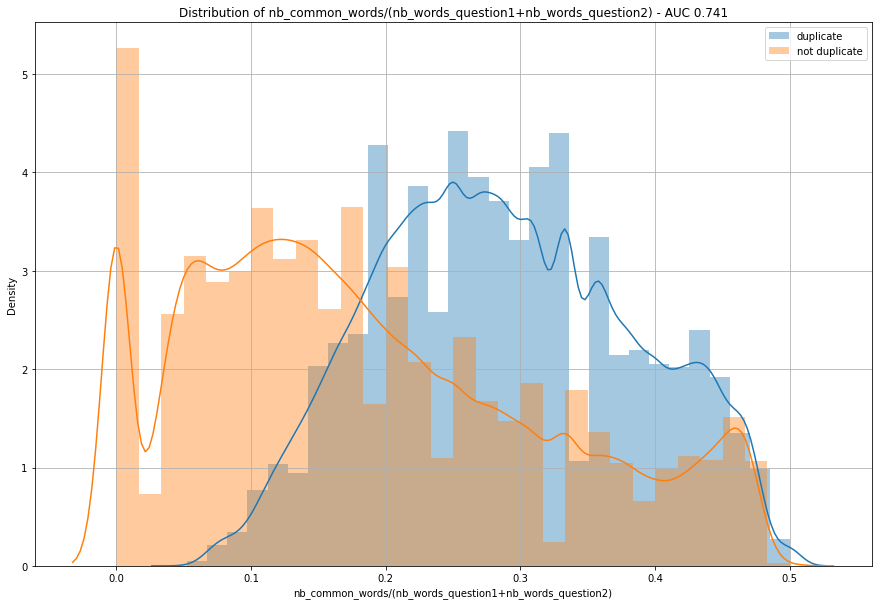

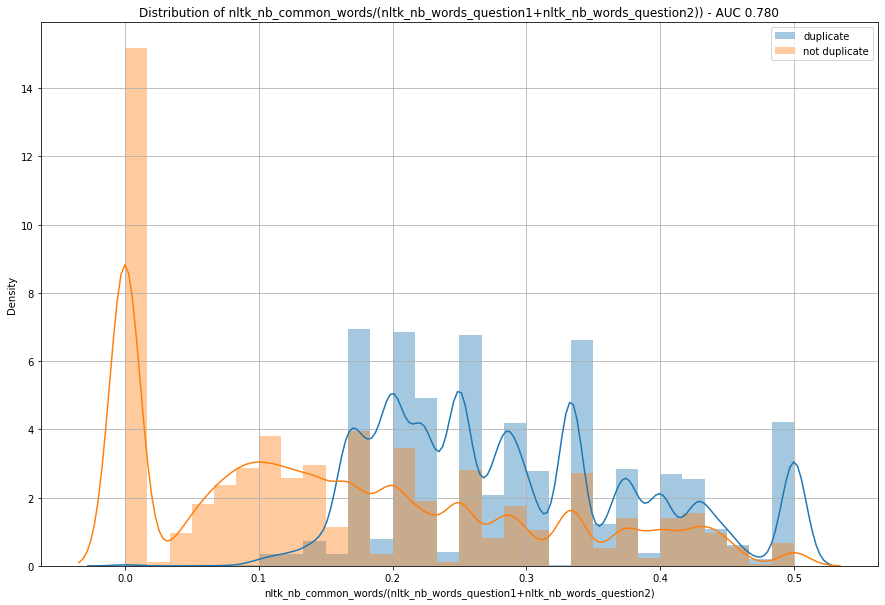

In [13]:
plot.figure(figsize=(15,10))
sns.distplot(train_dataframe[train_dataframe['is_duplicate']==1]['nb_common_words/(nb_words_question1+nb_words_question2)'], bins=30, label='duplicate', kde=True)  
sns.distplot(train_dataframe[train_dataframe['is_duplicate']==0]['nb_common_words/(nb_words_question1+nb_words_question2)'], bins=30,   label='not duplicate', kde=True)
plot.title('Distribution of nb_common_words/(nb_words_question1+nb_words_question2) - AUC %.3f' %simple_weighted_AUC(train_dataframe,'nb_common_words/(nb_words_question1+nb_words_question2)'))
plot.grid(True)
plot.legend()
plot_save('distribution_ratio_no_stopwords')

plot.figure(figsize=(15,10))
sns.distplot(train_dataframe[train_dataframe['is_duplicate']==1]['nltk_nb_common_words/(nltk_nb_words_question1+nltk_nb_words_question2)'], bins=30, label='duplicate', kde=True)    
sns.distplot(train_dataframe[train_dataframe['is_duplicate']==0]['nltk_nb_common_words/(nltk_nb_words_question1+nltk_nb_words_question2)'], bins=30,   label='not duplicate', kde=True)
plot.title('Distribution of nltk_nb_common_words/(nltk_nb_words_question1+nltk_nb_words_question2)) - AUC %.3f' %simple_weighted_AUC(train_dataframe,'nltk_nb_common_words/(nltk_nb_words_question1+nltk_nb_words_question2)'))
plot.grid(True)
plot.legend()
plot_save('distribution_ratio_nltk_stopwords')


This not really used at this step but we can do a lot when speaking of univaried statistics

is_duplicate                                                              1.000000
all_nb_common_words/(all_nb_words_question1+all_nb_words_question2)       0.456488
nltk_nb_common_words/(nltk_nb_words_question1+nltk_nb_words_question2)    0.456047
all_nb_common_words/all_nb_words_question1                                0.447348
nltk_nb_common_words/nltk_nb_words_question1                              0.445528
all_nb_common_words/all_nb_words_question2                                0.440822
nltk_nb_common_words/nltk_nb_words_question2                              0.440107
nb_common_words/(nb_words_question1+nb_words_question2)                   0.385462
nb_common_words/nb_words_question2                                        0.373299
nb_common_words/nb_words_question1                                        0.372102
all_nb_words_question1-all_common_words                                   0.342043
nltk_nb_words_question1-nltk_common_words                                 0.336392
all_

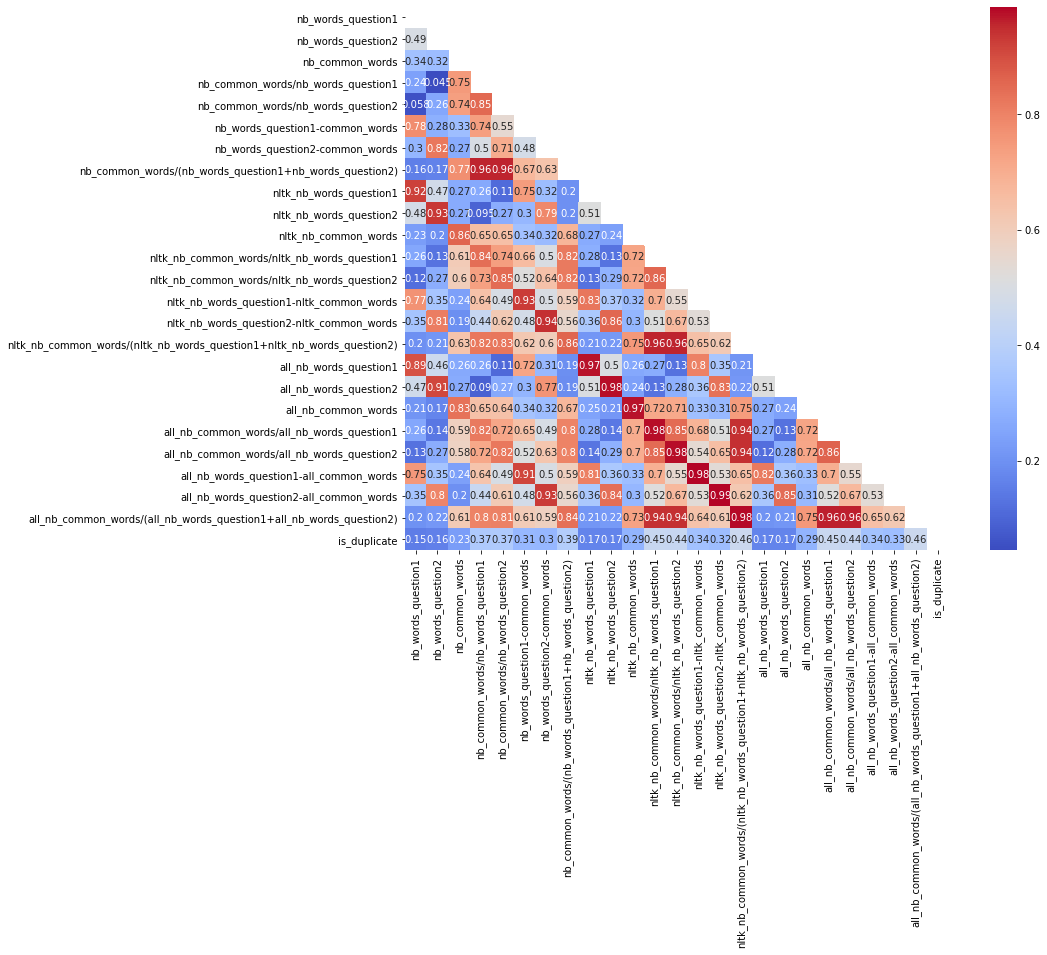

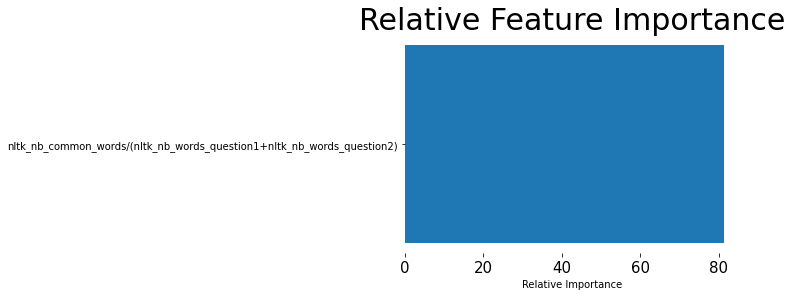

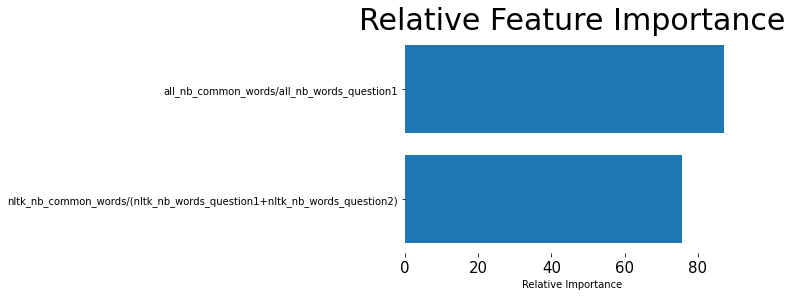

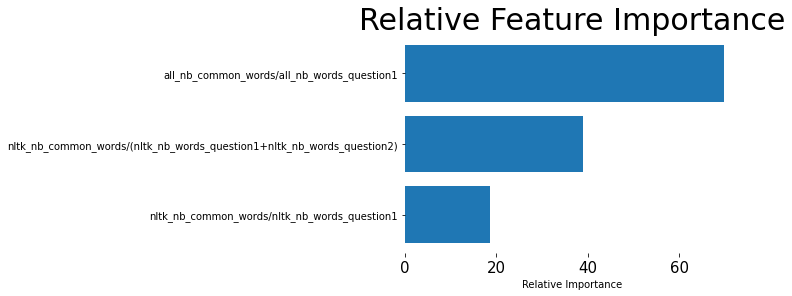

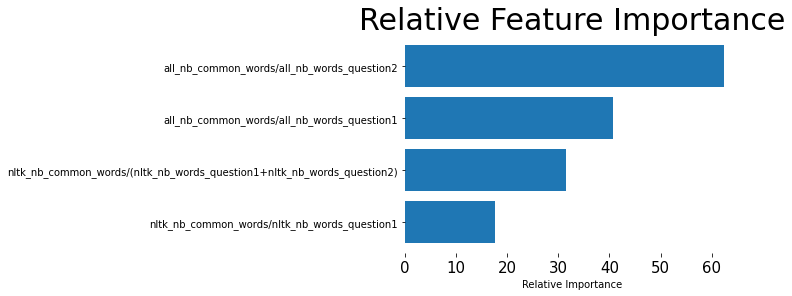

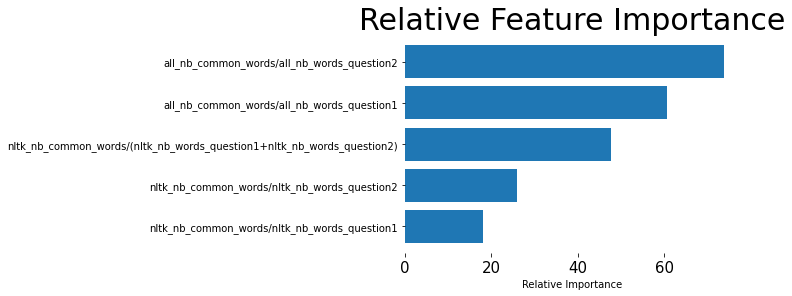

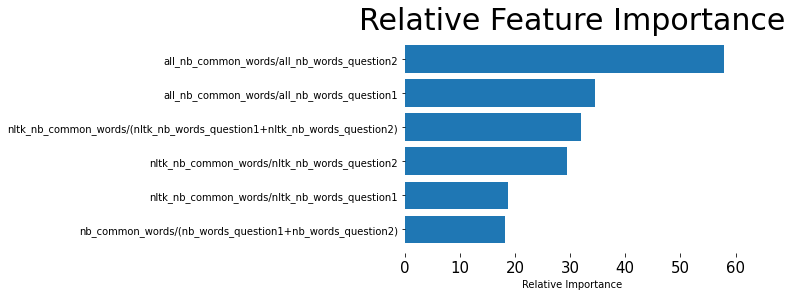

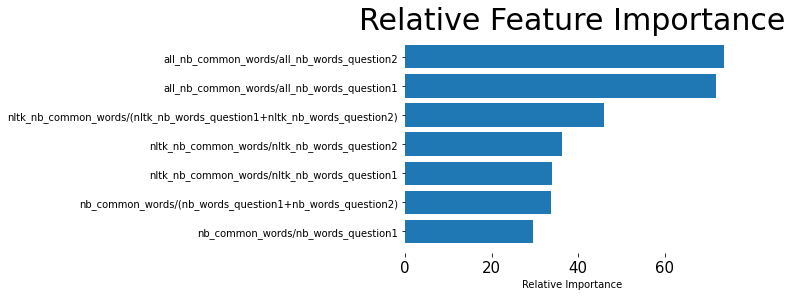

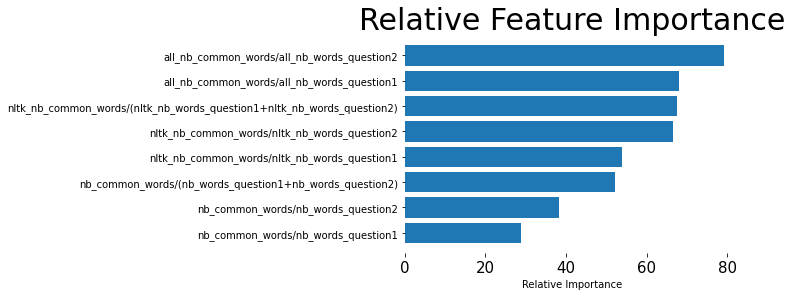

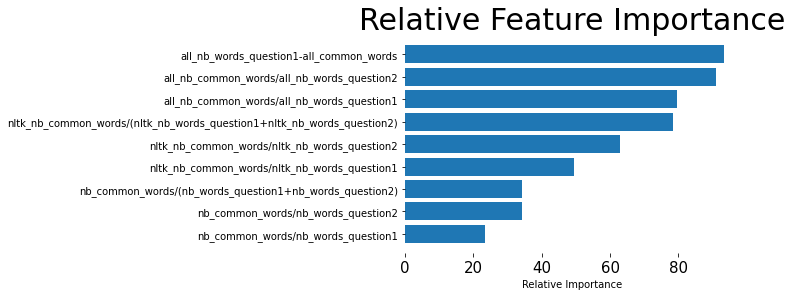

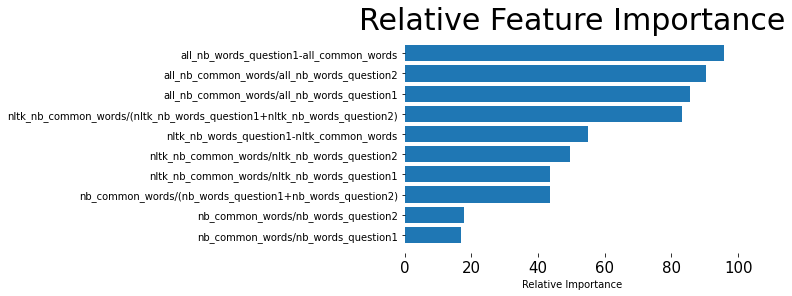

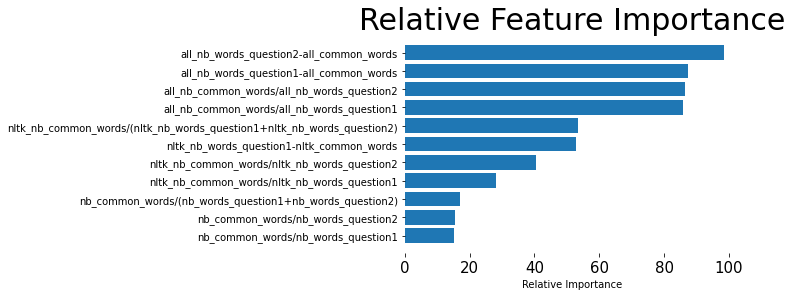

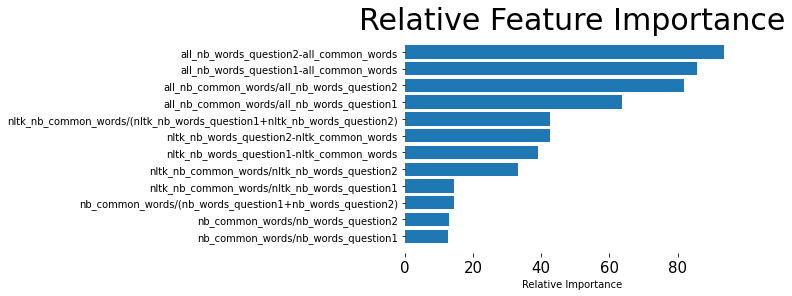

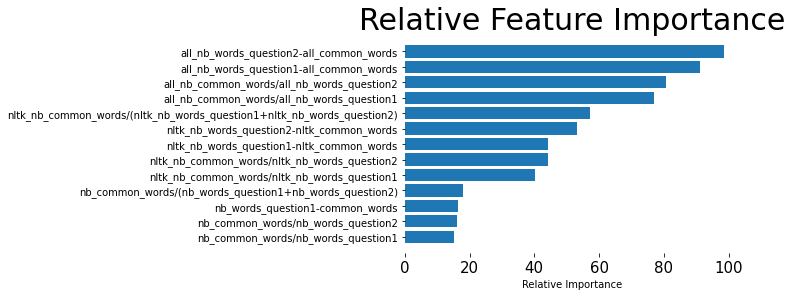

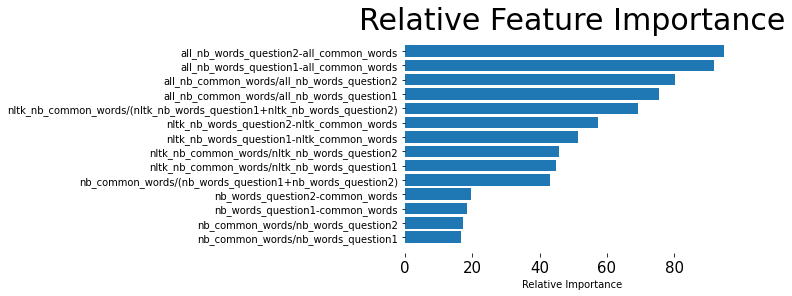

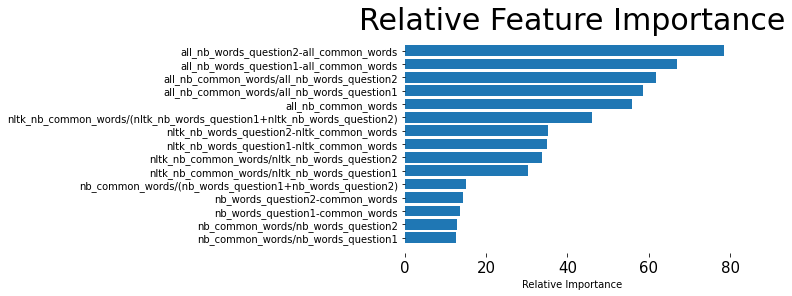

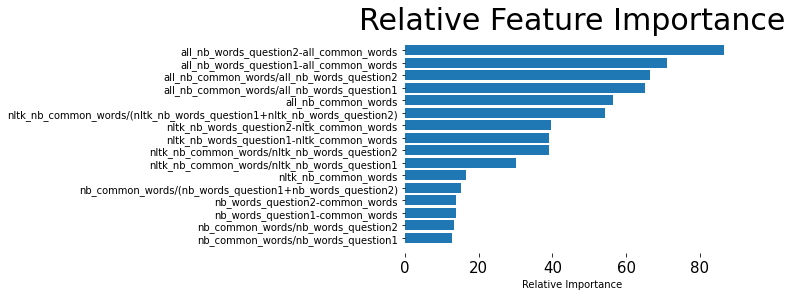

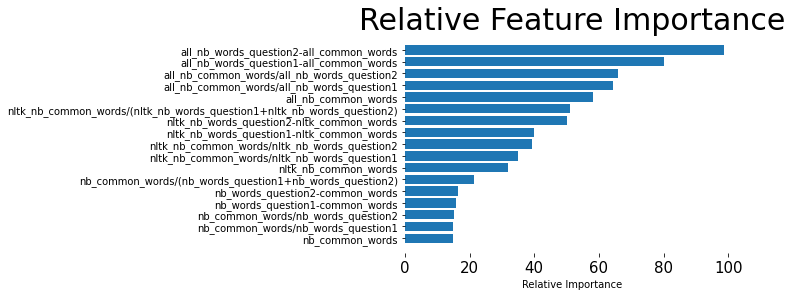

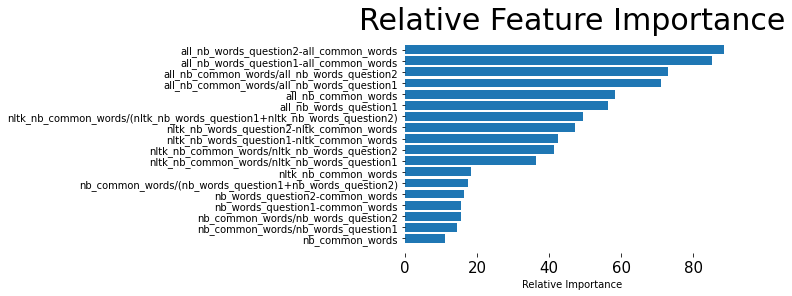

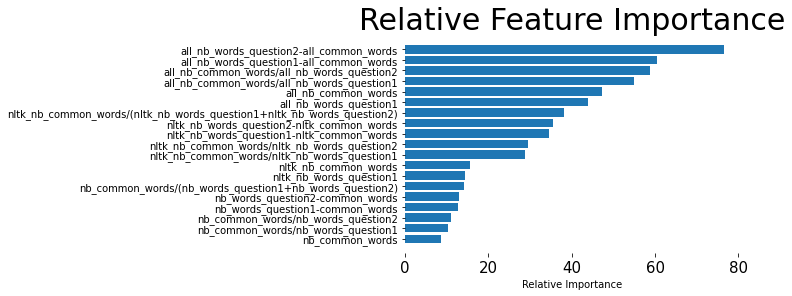

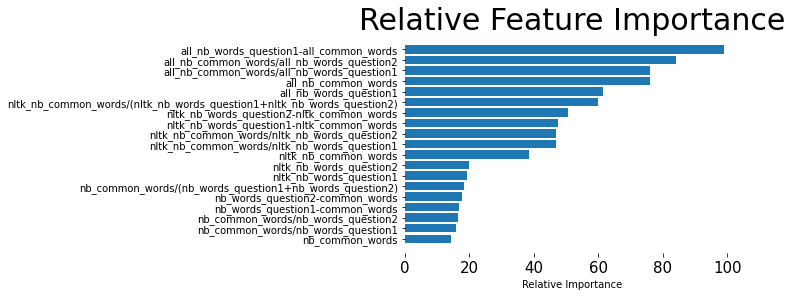

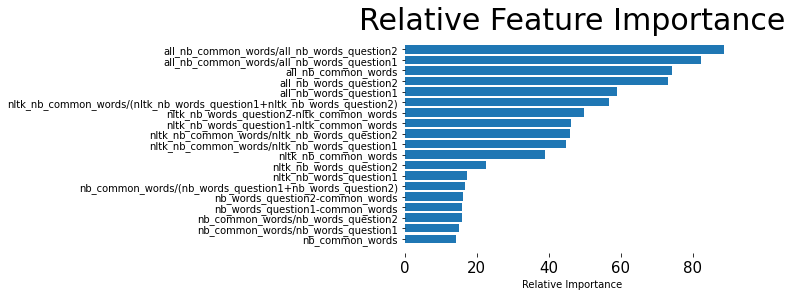

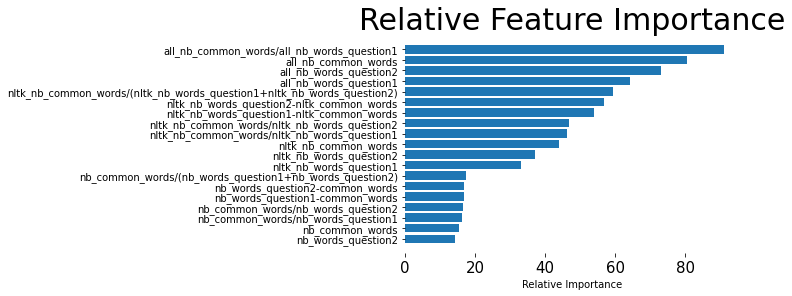

[ 3  4  7 11 12 15 19 20 23]
[0.12150257 0.12315636 0.14473293 0.09279793 0.09855551 0.158164
 0.05908282 0.05589664 0.14611124]


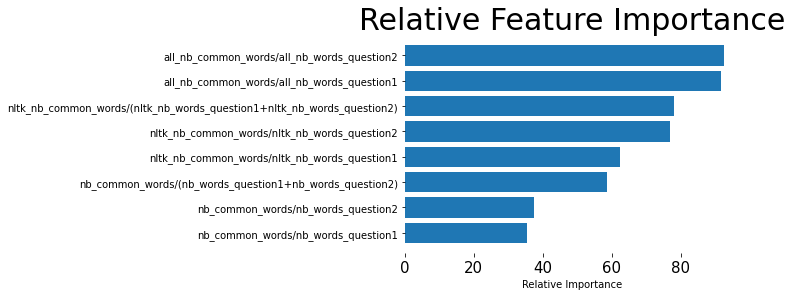

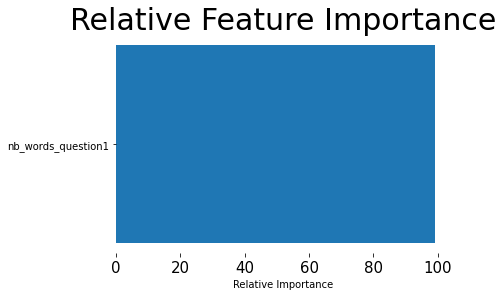

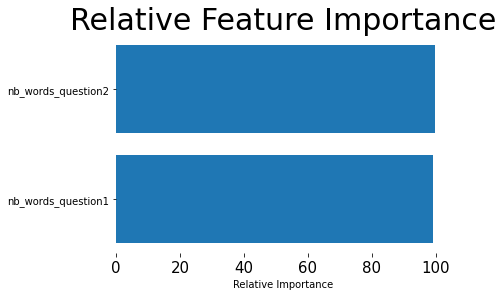

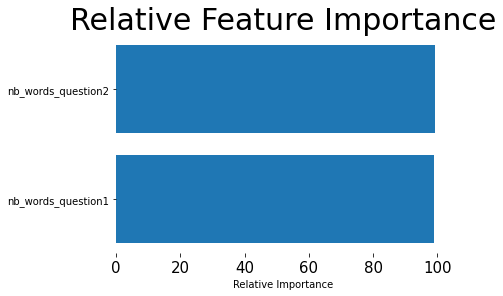

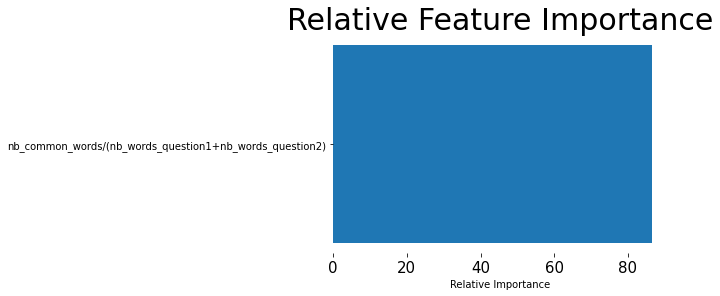

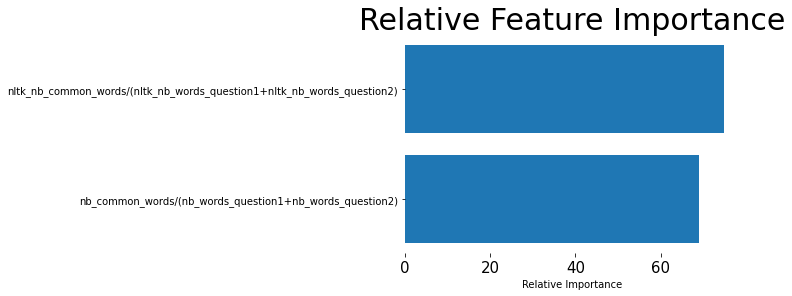

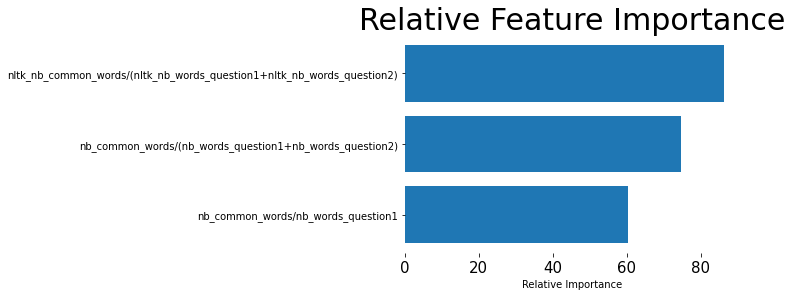

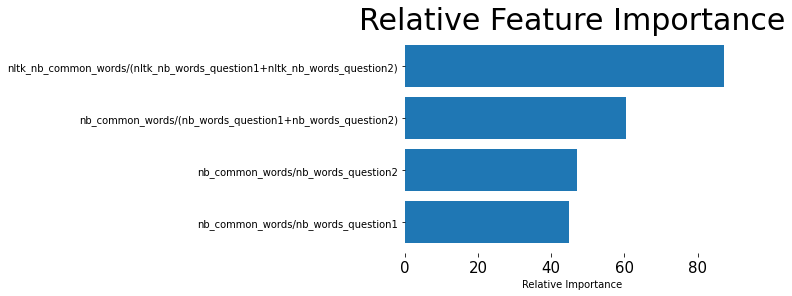

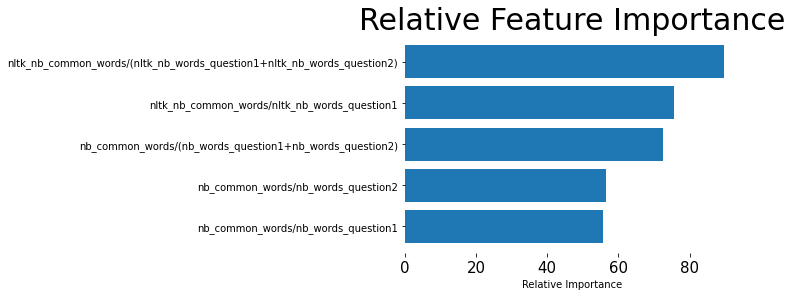

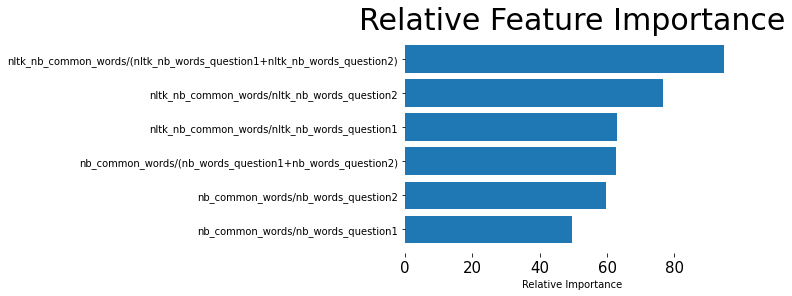

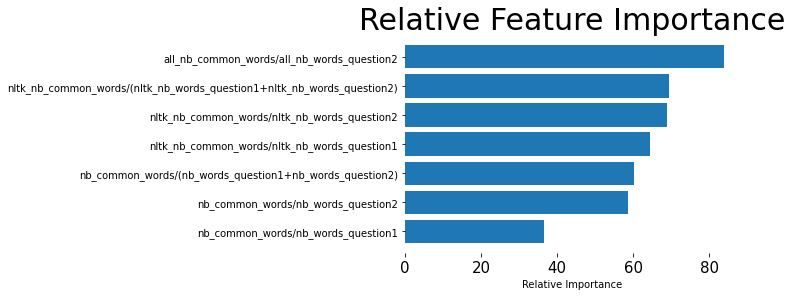

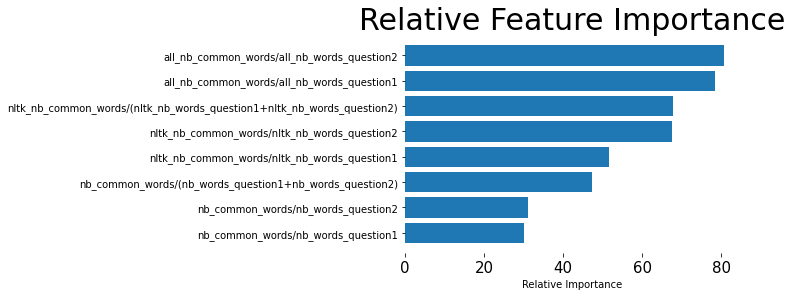

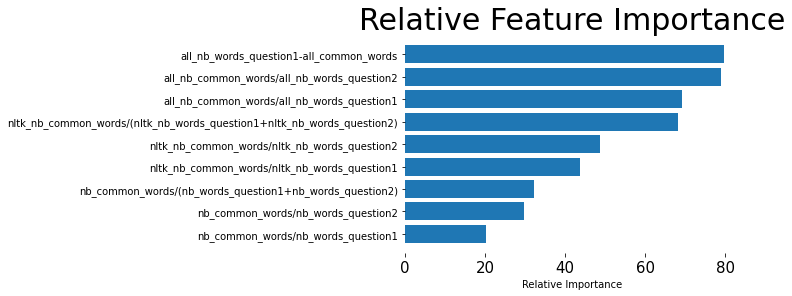

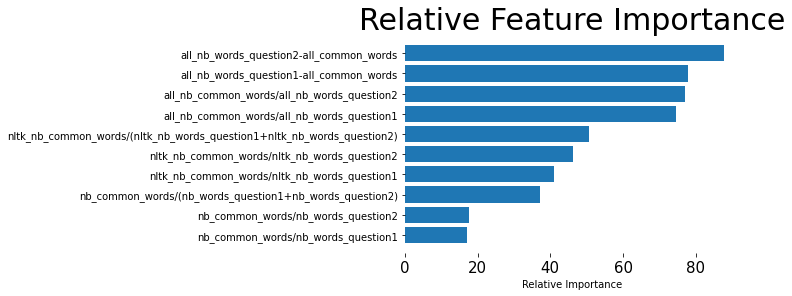

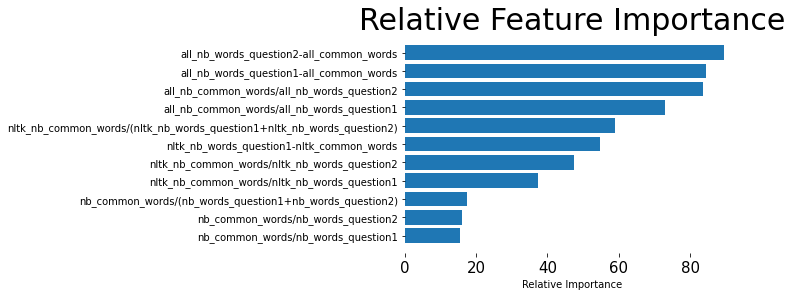

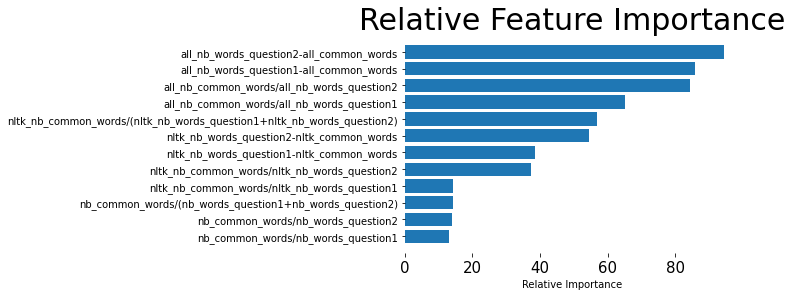

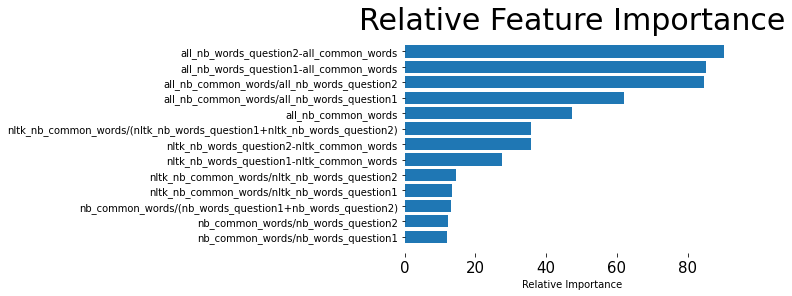

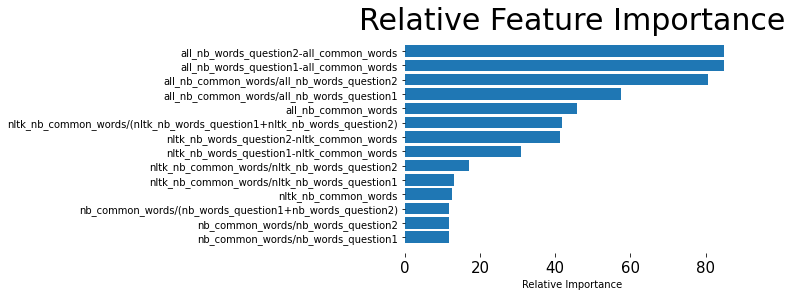

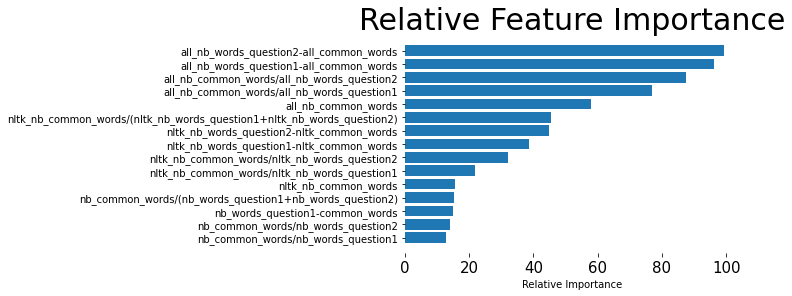

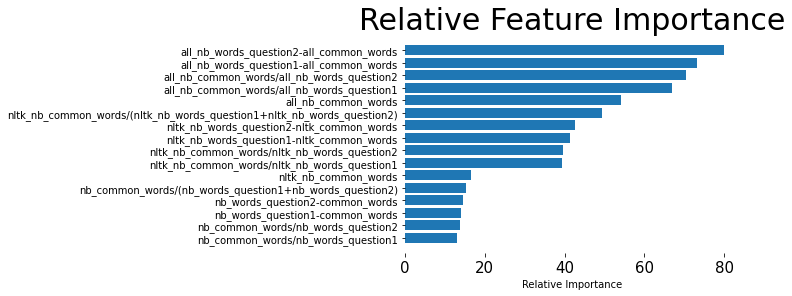

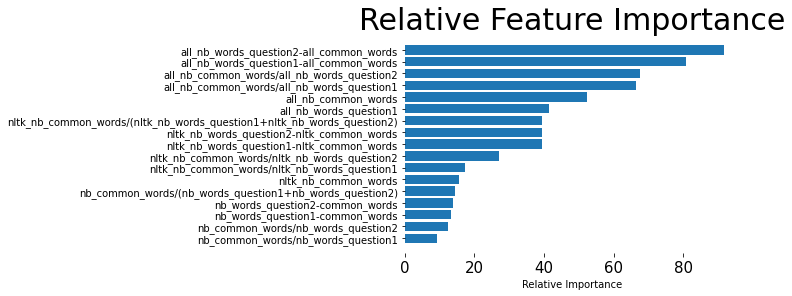

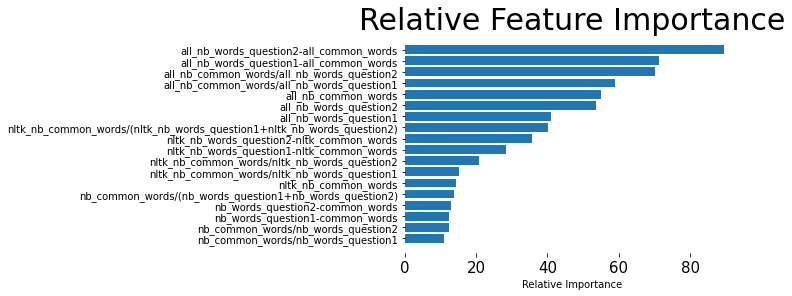

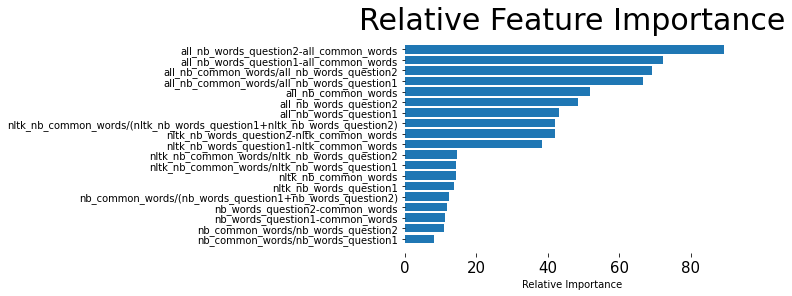

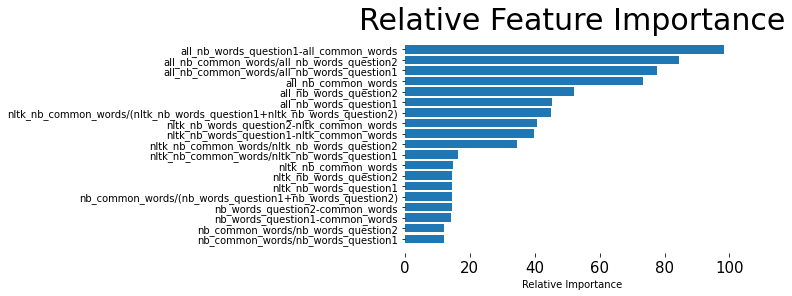

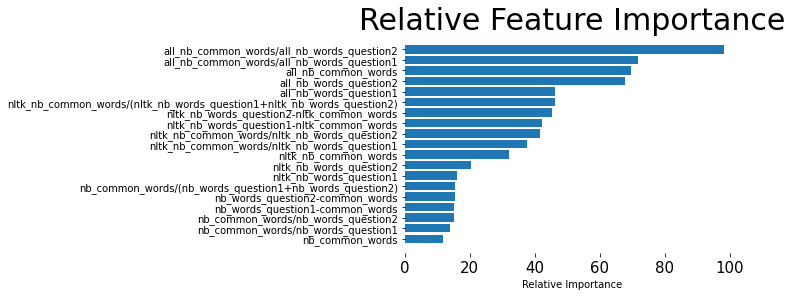

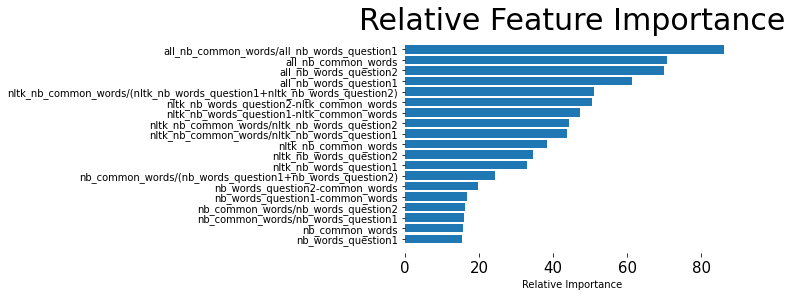

In [14]:
from sklearn import feature_selection
from sklearn.feature_selection import SelectKBest,f_classif,RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA

def graph_relative_feature_importance(features_importances,columns):
    # Make importances relative to max importance.
    features_importances = 100.0 * (features_importances / features_importances.max())
    sorted_idx = numpy.argsort(features_importances)
    sorted_idx = sorted_idx[-20:-1:1]
    pos = numpy.arange(sorted_idx.shape[0]) + 0.5
    plot.barh(pos, features_importances[sorted_idx], align='center')
    plot.yticks(pos, columns)
    plot.xlabel('Relative Importance')
    plot.title('Relative Feature Importance', fontsize=30)
    plot.tick_params(axis='x', which='major', labelsize=15)
    sns.despine(left=True, bottom=True)
    plot.show()

def graph_feature_importance(features_importances,columns):
    # Make importances relative to max importance.
    sorted_idx = numpy.argsort(features_importances)
    sorted_idx = sorted_idx[-20:]
    pos = numpy.arange(sorted_idx.shape[0]) + 0.5
    plot.barh(pos, features_importances[sorted_idx], align='center')
    plot.yticks(pos, columns)
    plot.xlabel('Importance')
    plot.title('Feature Importance', fontsize=30)
    plot.tick_params(axis='x', which='major', labelsize=15)
    #sns.despine(left=True, bottom=True)
    plot.show()

def independant_features_analysis(name_data,input_df,target_df):
    train_df = input_df[all_numeric_columns(input_df)]
    target_df = target_df
    small = int(len(target_df)*0.05)
    small_train = train_df.sample(small,random_state=42)
    small_target = target_df.sample(small,random_state=42)
    small_weights = input_df[WEIGHT].sample(small,random_state=42)

    # be careful all_numeric will include also the target soon
    all_numeric = all_numeric_columns(input_df)
    print_section('Minimal analysis of numeric features of %s' % name_data)
    print_info('Nb features: %d' % len(all_numeric))
    print_info(str(all_numeric))
    print_warning('Is there any null value ? %s' % input_df.isnull().any().any())

    compute_variances = feature_selection.VarianceThreshold()
    all_numeric.append('is_duplicate')
    variances = compute_variances.fit_transform(input_df[all_numeric])
    print_warning('Is there any low variance feature ? %s' % str(variances.shape[1]!=len(all_numeric)))
    print_info('Here are the correlations to the target "is_duplicate"')
    correlation_matrix = input_df[all_numeric].corr().abs()
    print(correlation_matrix['is_duplicate'].nlargest(len(all_numeric)))

    correlation_matrix_without_is_duplicate = correlation_matrix['is_duplicate'][correlation_matrix['is_duplicate']<1]
    highest_correlated_feature = correlation_matrix_without_is_duplicate.nlargest(1).index[0]
    highest_correlation = correlation_matrix_without_is_duplicate.nlargest(1)[0]
    if highest_correlation >0.2:
        if highest_correlation < 0.5:
            print_warning('%s is the most correlated with target but %f is quite weak' % (highest_correlated_feature,highest_correlation))
        else:
            print_info('%s is the most correlated with target but %f is very weak' % (highest_correlated_feature,highest_correlation))
    else:
        print_alert('%s is the most correlated with target and %f is quite big' % (highest_correlated_feature,highest_correlation))
    plot.figure(figsize=(15, 10))
    sns.heatmap(correlation_matrix,annot=True,cbar=True,square=True,cmap='coolwarm',mask = numpy.triu(correlation_matrix))
    plot.show()

    # we keep only numeric features and remove is_duplicate
    all_numeric = all_numeric_columns(input_df)

    print_section('Here are the features that would be selected with a simple univariate analysis')
    start = time.time()
    for r in tqdm(range(1,len(all_numeric))):
        k_best = SelectKBest(score_func=f_classif,k=r)
        fit = k_best.fit(small_train,small_target)
        best_columns = [small_train.columns[c] for c in fit.get_support(indices=True)]
        print_info('Nb features to keep %d:%s' %(r,best_columns))
        
        # Can we graph relative importances
        if r>1:
            # transform train set so we can compute importances
            univariate_features = fit.transform(small_train)
            rfc = RandomForestClassifier(n_estimators=100)
            rfc_scores = cross_val_score(rfc, univariate_features, small_target, cv=5, scoring='neg_log_loss',n_jobs=os.cpu_count())
            features_importance = rfc.fit(univariate_features, small_target).feature_importances_
            graph_relative_feature_importance(features_importance,best_columns)
    print_done('Done',top=start)
    
    print_section('Here are the features that would be selected a priori from default Multinomial Naive Bayes')
    start = time.time()   
    mnb = MultinomialNB()
    best_from_model = feature_selection.SelectFromModel(mnb)
    fit = best_from_model.fit(small_train,small_target,sample_weight=small_weights)
    print(fit.get_support(indices=True))
    best_columns = [small_train.columns[c] for c in fit.get_support(indices=True)]
    # transform train set so we can compute importances
    mnb_features = fit.transform(small_train)
    rfc = RandomForestClassifier(n_estimators=100)
    rfc_scores = cross_val_score(rfc, mnb_features, small_target, cv=5, scoring='neg_log_loss',n_jobs=os.cpu_count())
    features_importance = rfc.fit(mnb_features, small_target).feature_importances_
    print(features_importance)
    print_info('features to keep :%s logloss %.4f %.4f' %(best_columns,-rfc_scores.mean(),rfc_scores.std()))
    graph_relative_feature_importance(features_importance,best_columns)
    print_done('Done',top=start)
    

    print_info('Try to keep x \% of variance with a PCA')
    print_alert('bug ?')
    start = time.time()
    for r in tqdm([.8,.9,.95]):
        acp = PCA(r)
        principal_components = acp.fit_transform(small_train)
        principal_df = pandas.DataFrame(principal_components).sample(small,random_state=42)
        rfc = RandomForestClassifier(n_estimators=100)
        rfc_scores = cross_val_score(rfc, principal_df, small_target, cv=5, scoring='neg_log_loss',n_jobs=os.cpu_count())
        features_importance = rfc.fit(principal_df, small_target).feature_importances_
        print_info('%% of variance %f:%s' %(r,'aie'))
        graph_relative_feature_importance(features_importance,small_train.columns)
    print_done('Done',top=start)

    print_section('Here are the features that would be selected with a recursive feature elimination')
    start = time.time()
    print_alert('Doomed to fail : RFE does not support to transmit ,sample_weight=small_weights')
    print_alert('ix is waiting since 2016 ?')
    for r in tqdm(range(1,len(all_numeric))):
        mnb = MultinomialNB()
        recursive_best= feature_selection.RFE(mnb, n_features_to_select=r)
        fit = recursive_best.fit(small_train,small_target)
        best_columns = [small_train.columns[c] for c in fit.get_support(indices=True)]
        print_info('Nb features to keep %d:%s' %(r,best_columns))
        
        # Can we graph relative importances
        if r>1:
            # transform train set so we can compute importances
            recursive_features = fit.transform(small_train)
            rfc = RandomForestClassifier(n_estimators=100)
            rfc_scores = cross_val_score(rfc, recursive_features, small_target, cv=5, scoring='neg_log_loss',n_jobs=os.cpu_count())
            features_importance = rfc.fit(recursive_features, small_target).feature_importances_
            graph_relative_feature_importance(features_importance,best_columns)
    print_done('Done',top=start)

independant_features_analysis('train',train_dataframe,train_dataframe['is_duplicate'])

Let's recap our available features

In [15]:
ALL_FEATURES=all_numeric_columns(train_dataframe)
print_info('We have %d features' % len(ALL_FEATURES))
display(pandas.DataFrame(ALL_FEATURES,columns=['feature']))

feature
0                                                       nb_words_question1
1                                                       nb_words_question2
2                                                          nb_common_words
3                                       nb_common_words/nb_words_question1
4                                       nb_common_words/nb_words_question2
5                                          nb_words_question1-common_words
6                                          nb_words_question2-common_words
7                  nb_common_words/(nb_words_question1+nb_words_question2)
8                                                  nltk_nb_words_question1
9                                                  nltk_nb_words_question2
10                                                    nltk_nb_common_words
11                            nltk_nb_common_words/nltk_nb_words_question1
12                            nltk_nb_common_words/nltk_nb_words_question2
13                               nltk_nb_words_question1-nltk_common_words
14                               nltk_nb_words_question2-nltk_common_words
15  nltk_nb_common_words/(nltk_nb_words_question1+nltk_nb_words_question2)
16                                                  all_nb_words_question1
17                                                  all_nb_words_question2
18                                                     all_nb_common_words
19                              all_nb_common_words/all_nb_words_question1
20                              all_nb_common_words/all_nb_words_question2
21                                 all_nb_words_question1-all_common_words
22                                 all_nb_words_question2-all_common_words
23     all_nb_common_words/(all_nb_words_question1+all_nb_words_question2)

Exploring each combination of these 24 features (like we did in a first experiment with basic features) is not practical. We will just add one field at a time, build a model, keep metrics and figure what is happening.

A bunch of code to build xgboost models with basic set of parameters
The criteria to stop learning is aligned to kaggle's one: *logloss*

In [16]:
# Simple XGBoost code
# 

import xgboost 

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta' : 0.02,
    'max_depth':3 
    }

def print_res_xgboost(infos):
    # Glurk
    print_info(' | '.join([('%s '+f) % (k,infos[k]) for k,f in INFO_XGBOOST_MODEL.items() if k in infos]))

# 80% training 20% validation
def build_XGBoost_model_80_20(training,target,column_names,show=True):
    input_train,input_test,target_train,target_test = train_test_split(training,target,random_state=42,test_size=0.2)
    final_input_train = input_train[list(column_names)]
    final_input_test = input_test[list(column_names)]
    train_dm = xgboost.DMatrix(final_input_train, label = target_train, weight = input_train[WEIGHT],nthread = -1)
    validation_dm = xgboost.DMatrix(final_input_test, label = target_test,weight = input_test[WEIGHT])
    watchlist = [(train_dm, 'train'), (validation_dm, 'valid')]

    start = time.time()
    if show:
        verbose = 10
    else:
        verbose = 0
    model = xgboost.train(params,train_dm,400,watchlist,early_stopping_rounds=50,verbose_eval=verbose)
    infos = compute_metrics_model_xgboost(model,final_input_test,target_test,sample_weight = input_test[WEIGHT],show=show)
    duration = time.time()-start
    infos.update({'time':duration})
    if show:      
        print_res_xgboost(infos)
    return  infos

# Pushing the limits :100 % training no validation !!
# Just in case it allows to gain small digits in kaggle score...
# Actually not used ...
def build_XGBoost_model_100_0(training,target,column_names,show=True):
    final_train = training[list(column_names)]
    final_target = target
    final_weight = training[WEIGHT]

    train_dm = xgboost.DMatrix(final_train, label = final_target, weight = final_weight,nthread = -1)
    watchlist = [(train_dm, 'train')]

    start = time.time()
    if show:
        verbose = 10
    else:
        verbose = 0
    model = xgboost.train(params,train_dm,400,watchlist,early_stopping_rounds=50,verbose_eval=verbose)
    duration = time.time()-start
    infos = compute_metrics_model_xgboost(model,final_train,final_target,sample_weight = final_weight,show=show)
    infos.update({'time':duration})
    if show:      
        print_res_xgboost(infos)
    return  infos

def compute_metrics_model_xgboost(model,input_df,target_df,sample_weight = None,show = True):
    final_input = xgboost.DMatrix(input_df)
    prediction_proba_df = model.predict(final_input,ntree_limit=model.best_ntree_limit)
    # Hum shouldn't we challenge this 50% threshold ?
    prediction_df = numpy.where(prediction_proba_df>0.5,1,0)
    res = metrics.classification_report(target_df,prediction_df,sample_weight = sample_weight,output_dict=True)
    accuracy = res['accuracy']
    score = res['weighted avg']['f1-score']
    logloss_proba = metrics.log_loss(target_df,prediction_proba_df,sample_weight = sample_weight)
    if show:
        print_info('Classification report')
        print(metrics.classification_report(target_df,prediction_df,sample_weight = sample_weight))
    return {
             'accuracy':accuracy,
             'score':score,
             'logloss_proba':logloss_proba,
             'model':model
           }

INFO_XGBOOST_MODEL= {
    'logloss_proba': '%.4f',
    'score': '%.4f',
    'accuracy': '%.4f',
    'time': '%.2f'
}

if UNITARY_TEST:
    print_section('Unitary test : playbox XGBoost 80_20')
    small_train = train_dataframe.sample(1000,random_state=42)
    print_section('Unitary test : playbox XGBoost 100_0')
    res = build_XGBoost_model_100_0(small_train,small_train['is_duplicate'],all_numeric_columns(small_train))
    print(res)

if UNITARY_TEST:
    print_section('Unitary test : playbox XGBoost 80_20')
    small_train = train_dataframe.sample(1000,random_state=42)
    print_section('Unitary test : playbox XGBoost 80_20')
    res = build_XGBoost_model_80_20(small_train,small_train['is_duplicate'],all_numeric_columns(small_train))
    print(res)

[0]	train-logloss:0.68204
Will train until train-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.59118
[20]	train-logloss:0.52665
[30]	train-logloss:0.47925
[40]	train-logloss:0.44336
[50]	train-logloss:0.41559
[60]	train-logloss:0.39372
[70]	train-logloss:0.37646
[80]	train-logloss:0.36268
[90]	train-logloss:0.35138
[100]	train-logloss:0.34187
[110]	train-logloss:0.33398
[120]	train-logloss:0.32764
[130]	train-logloss:0.32254
[140]	train-logloss:0.31835
[150]	train-logloss:0.31446
[160]	train-logloss:0.31107
[170]	train-logloss:0.30793
[180]	train-logloss:0.30544
[190]	train-logloss:0.30312
[200]	train-logloss:0.30088
[210]	train-logloss:0.29918
[220]	train-logloss:0.29724
[230]	train-logloss:0.29564
[240]	train-logloss:0.29413
[250]	train-logloss:0.29242
[260]	train-logloss:0.29082
[270]	train-logloss:0.28914
[280]	train-logloss:0.28763
[290]	train-logloss:0.28625
[300]	train-logloss:0.28497
[310]	train-logloss:0.28329
[320]	train-logloss:0.28194
[330]	train-logloss:0.2807

              precision    recall  f1-score   support

           0       0.87      0.99      0.92 833.5098453967706
           1       0.81      0.25      0.39 171.66892895091271

    accuracy                           0.86 1005.1787743476833
   macro avg       0.84      0.62      0.65 1005.1787743476833
weighted avg       0.86      0.86      0.83 1005.1787743476833



{'accuracy': 0.8620857350504291, 'score': 0.8306662715431401, 'logloss_proba': 0.27059263915834647, 'model': <xgboost.core.Booster object at 0x7f95b5b8fd60>, 'time': 21.36710262298584}


[0]	train-logloss:0.68248	valid-logloss:0.68185
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.59441	valid-logloss:0.58779
[20]	train-logloss:0.53155	valid-logloss:0.52159
[30]	train-logloss:0.48463	valid-logloss:0.47264
[40]	train-logloss:0.44904	valid-logloss:0.43490
[50]	train-logloss:0.42169	valid-logloss:0.40652
[60]	train-logloss:0.39982	valid-logloss:0.38435
[70]	train-logloss:0.38266	valid-logloss:0.36697
[80]	train-logloss:0.36899	valid-logloss:0.35306
[90]	train-logloss:0.35824	valid-logloss:0.34300
[100]	train-logloss:0.34951	valid-logloss:0.33566
[110]	train-logloss:0.34207	valid-logloss:0.32995
[120]	train-logloss:0.33565	valid-logloss:0.32446
[130]	train-logloss:0.33037	valid-logloss:0.32081
[140]	train-logloss:0.32558	valid-logloss:0.31698
[150]	train-logloss:0.32159	valid-logloss:0.31383
[160]	train-logloss:0.31835	valid-logloss:0.31162
[170]	trai

              precision    recall  f1-score   support

           0       0.86      0.97      0.91 168.7955573880411
           1       0.59      0.23      0.33 33.5771183347514

    accuracy                           0.85 202.37267572279248
   macro avg       0.73      0.60      0.62 202.37267572279248
weighted avg       0.82      0.85      0.82 202.37267572279248



{'accuracy': 0.8456095199583094, 'score': 0.8155027441366446, 'logloss_proba': 0.2938569771609135, 'model': <xgboost.core.Booster object at 0x7f95b5ba4670>, 'time': 23.156505823135376}


Another bunch of code. Just wrappers so we do in one shot:
* generate a set of models given a set of columns
* keep their results in memory
* save all models to excel
* dump everything (including the models) in a cache so all previous steps can be done in a sec
* find the best model (related to logloss)
* generate a file of predictions suitable for kaggle
* prepare everything for a kaggle submission
* show the statement to do the submission to kaggle


Current exploration methods available, given n columns
* generate models using from 1 to n columns (24 columns will generate 24 models)
* only one model with all the columns provided as parameter

In [19]:
def find_best_result(results,metric):
    if 'logloss' in metric:
        return results.nsmallest(1,metric)
    else:
        return results.nlargest(1,metric)
        
def apply_xgboost(model,columns,input_df):
    res = pandas.DataFrame()
    res['test_id'] = input_df['test_id']
    res['is_duplicate'] = model.predict(xgboost.DMatrix(input_df[columns]))
    return res

def submit_best_result(results,input_df,file_name,kaggle_message,metric='logloss_proba'):
    start = time.time()
    print_section("Scoring XGBoost model with best %s: %s" % (metric,kaggle_message))
    csv_file_name = absolute_env_file_name(file_name,ext='.csv')
    print_info('Generating scores in %s' % csv_file_name)
    best = find_best_result(results,metric)
    model = best['model'][0]
    columns = best['columns'][0]
    prediction = apply_xgboost(model,columns,input_df)
    prediction.to_csv(csv_file_name,index=False)
    print_info('Zipping file')
    absolute_file_name_zip = zip_file_and_delete(csv_file_name)
    print_done('Done',top=start)
    print_info('%s is ready' % absolute_file_name_zip)
    print_warning('Use this commands to submit apply results to kaggle')
    print_warning('kaggle competitions submit quora-question-pairs -f "%s" -m "%s %s"' % (absolute_file_name_zip,EXPERIMENT,kaggle_message))
    return prediction

def n_columns(columns,n):
    return columns[0:n]

def xgboost_80_20_one_more_field_at_a_time(dataframe,columns_to_explore,explore=True,show=False):
    if explore:
        print_section("XGBoost (80,20) on 1 to %d fields" % len(columns_to_explore))
    else:
        print_section("XGBoost (80,20) on %d fields" % len(columns_to_explore))
    start = time.time()
    res_final = dict()
    min_log_loss = 1000
    best = 0
    best_cols =''
    # a shortcut is possible
    if explore:
        first_nb = 1
    else:
        first_nb=len(columns_to_explore)
    for i in tqdm(range(first_nb,len(columns_to_explore)+1)):
        columns = n_columns(columns_to_explore,i)
        res = build_XGBoost_model_80_20(dataframe,dataframe['is_duplicate'],columns,show = show)
        cur_logloss = res['logloss_proba']
        cur_accuracy = res['accuracy']
        cur_score = res['score']
        if cur_logloss<min_log_loss:
            print_info("%d:%.4f %.4f %.4f %s" % (i,cur_logloss,cur_accuracy,cur_score,columns))
            min_log_loss = cur_logloss
            best_cols = columns
            best = i
        else:
            print_warning("%d:%.4f %.4f %.4f %s" % (i,cur_logloss,cur_accuracy,cur_score,columns))
        res.update( {'columns':columns})
        res_final.update({str(i):res})
    print_info('Best: %d %.4f %s' % (best,min_log_loss,best_cols))
    print_done('Done',top=start)
    return pandas.DataFrame.from_dict(res_final, orient='index')

# try to reload from cache an exploration
# if not available, redo it and save results in cache
# find the best result according to a metric (default logloss_proba)
# and submit it to kaggle
def study_models_one_more_field_at_a_time(message,tag,columns,train_df,challenge_df,explore=True,show=False):
    print_section(message)
    results = load_or_build_dataframe('Rebuild XGBoost models',tag + '_results',lambda df:xgboost_80_20_one_more_field_at_a_time(df,columns,explore=explore,show=show),train_df)
    save_models_dict_to_excel(results,tag=tag)
    display(results.describe())
    #submit_best_result(results,challenge_df,'Best_'+tag,'Best ' + tag)
    return results

A little bit long but results are saved in a cache so next time will be fast

In [21]:
xgboost_everything_results = study_models_one_more_field_at_a_time(
    'all features_not_cleaned',
    'all_features_not_cleaned',
    ALL_FEATURES,
    train_dataframe,
    challenge_dataframe,
    explore = True,
    show = False)

KeyboardInterrupt: 

In [1]:

plot.figure(figsize=(10,10))

pal=sns.color_palette()
plot.ylimit(0.3,0.5)
plot.plot(numpy.arange(1,9,1),xgboost_everything_results['logloss_proba'][1:9],color=pal[1],alpha=0.3)
plot.fill_between(numpy.arange(1,9,1),xgboost_everything_results['logloss_proba'][1:9],label='basic',color=pal[1],alpha=0.3)

plot.plot(numpy.arange(8,17,1),xgboost_everything_results['logloss_proba'][8:17],color=pal[2],alpha=0.3)
plot.fill_between(numpy.arange(8,17,1),xgboost_everything_results['logloss_proba'][8:17],label='nltk stopwords',color=pal[2],alpha=0.3)

plot.plot(numpy.arange(16,24,1),xgboost_everything_results['logloss_proba'][16:24],color=pal[3],alpha=0.3)
plot.fill_between(numpy.arange(16,24,1),xgboost_everything_results['logloss_proba'][16:24],label='nltk +sklearn stopwords',color=pal[3],alpha=0.3)
plot.title('xgboost: logloss/Nb fields')
plot.xlabel('Nb fields')
plot.grid(True)
plot.legend()
#plot.plot(xgboost_everything_results['score'],label='f1-score')
#plot.plot(xgboost_everything_results['accuracy'],label='accuracy')

# xgboost_everything_results[['logloss_proba','accuracy','score']].plot(ax=ax)

NameError: name 'plot' is not defined

In [48]:
xgboost_everything_results.columns

Index(['accuracy', 'score', 'logloss_proba', 'model', 'time', 'columns'], dtype='object')